# Data Preparation & Function Generation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#모델 라이브러리 가져오기 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, auc
import seaborn as sns

In [ ]:
X_test = np.load('/content/drive/Shareddrives/2022-1 KUBIG 음악추천시스템/melspectogram_test_set.npy')
X_test.shape

X_test= np.concatenate([X_test[0:30], X_test[60:]])

In [ ]:
target = []
for i in range(30):
  target.append(0)
for i in range(30):
  target.append(1)
for i in range(30):
  target.append(2)
for i in range(30):
  target.append(3)


In [ ]:
y_test = np.array(target)

In [ ]:
import cv2
cv2.resize(X_test[0], (256, 256), interpolation = cv2.INTER_LANCZOS4).shape


from sklearn.preprocessing import StandardScaler

new = []
for i in range(120):
  scaler = StandardScaler()
  temp = scaler.fit_transform(X_test[i])
  new.append(cv2.resize(temp, (256, 256), interpolation = cv2.INTER_LANCZOS4))

In [ ]:
new2 = []
for i in range(120):
  new2.append(np.array([new[i], new[i], new[i]]))

In [ ]:
X_test = np.array(new2)
X_test.shape

(120, 3, 256, 256)

In [ ]:
X_test = np.swapaxes(np.swapaxes(X_test, 1, 2), 2, 3)

In [ ]:
X_test.shape

(120, 256, 256, 3)

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve_red(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 0.08)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'black', ax = ax, alpha = 0.05, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
def plot_roc_curve_red_2(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax, ci=None, color='red', alpha = 1)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
classes = [0, 1, 2, 3, 4]
classes_names = ['Hip hop', 'Dance', 'Trot', 'Ballad', 'Rock']

# Resnet50(05/18) - 800 train set

In [ ]:
testpred = []
testprob = []
for i in range(0, 5):
  resnet50 = load_model('/content/drive/MyDrive/musicrecommendation_resent50{zero}.h5'.format(zero = i))
  prob = resnet50.predict(X_test)
  testprob.append(prob)
  pred = np.argmax(prob, axis = 1)
  testpred.append(pred)
  

In [ ]:
testpred

[array([0, 0, 0, 0, 0, 4, 0, 3, 3, 0, 1, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4,
        0, 0, 0, 4, 0, 3, 0, 0, 4, 4, 1, 2, 0, 0, 4, 1, 4, 0, 1, 1, 1, 1,
        0, 4, 1, 2, 1, 0, 0, 3, 4, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2,
        1, 2, 3, 2, 4, 2, 2, 2, 2, 3, 0, 4, 3, 3, 3, 2, 1, 3, 3, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 4, 4, 3, 4, 2, 2, 4,
        0, 2, 4, 2, 2, 3, 2, 3, 0, 4, 4, 3, 3, 4, 4, 1, 0, 4]),
 array([0, 0, 0, 0, 0, 4, 0, 3, 3, 0, 1, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4,
        0, 0, 0, 4, 0, 3, 0, 0, 4, 4, 1, 4, 0, 0, 4, 1, 4, 0, 1, 1, 1, 1,
        0, 4, 1, 2, 1, 0, 0, 3, 4, 0, 0, 0, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2,
        1, 2, 3, 2, 4, 2, 2, 2, 2, 3, 0, 4, 3, 3, 3, 2, 1, 3, 3, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 4, 4, 3, 4, 2, 2, 4,
        0, 2, 4, 2, 2, 3, 2, 3, 0, 4, 4, 3, 3, 4

In [ ]:
for i in range(5):
  sum = 0
  sum_list = []
  for j in range(len(testpred[i])):
    if testpred[i][j] == y_test[j]:
      sum = sum + 1
  print(sum / len(testpred[1]) * 100)
  sum_list.append(sum / len(testpred[1]) * 100)

IndexError: ignored

In [ ]:
np.mean(sum_list)

58.666666666666664

IndexError: ignored

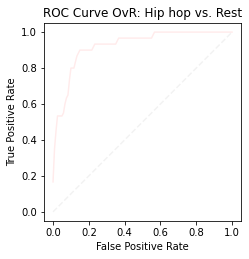

In [ ]:
plt.figure(figsize = (12, 8))
roc_auc_ovr = {}
auc = []
    
for i in range(len(classes)):
    
    temptpr = []
    tempfpr = []
    
    for j in range(5):

        c = classes[i]

        df_aux = pd.DataFrame(y_test).copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = np.array(testprob)[j][:, i]
        df_aux = df_aux.reset_index(drop = True)

        ax_bottom = plt.subplot(2, 3, i+2)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])


        temptpr.append(tpr)
        tempfpr.append(fpr)
        
        plot_roc_curve_red(tpr, fpr, scatter = False, ax = ax_bottom)
        
        
        ax_bottom.set_title(f"ROC Curve OvR: {classes_names[c]} vs. Rest")

        auc.append(roc_auc_score(df_aux['class'], df_aux['prob']))
    
    temptpr = np.array(temptpr)
    tempfpr = np.array(tempfpr)
    
    num = 9 + i * 10
    prev = 9 + (i-1)*10
    plot_roc_curve_red_2(np.sort(np.array(pd.DataFrame(temptpr).mean())), np.sort(np.array(pd.DataFrame(tempfpr).mean())), scatter = False, ax = ax_bottom)

    plt.tight_layout()

In [ ]:
testprob]

IndexError: ignored

# Resnet50(6/22) - 1000 train set with four classes(except dance)

In [ ]:
testpred = []
testprob = []
for i in range(0, 5):
  resnet50 = load_model('/content/drive/MyDrive/musicrecommendation_resent50withoutdance{zero}.h5'.format(zero = i))
  prob = resnet50.predict(X_test)
  testprob.append(prob)
  pred = np.argmax(prob, axis = 1)
  testpred.append(pred)

In [ ]:
testpred

[array([3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 1, 1, 3, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3,
        3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3,
        3, 3, 0, 2, 2, 1, 0, 3, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1,
        1, 3, 0, 2, 2, 2, 0, 1, 3, 2, 2, 1, 1, 3, 1, 1, 2, 2, 2, 2, 3, 2,
        2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3,
        3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 0, 1, 3, 0, 3, 3, 3, 3,
        3, 3, 0, 2, 3, 1, 0, 3, 0, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1,
        1, 3, 0, 2, 2, 2, 0, 1, 

In [ ]:
for i in range(5):
  sum = 0
  sum_list = []
  for j in range(len(testpred[i])):
    if testpred[i][j] == y_test[j]:
      sum = sum + 1
  print(sum / len(testpred[1]) * 100)
  sum_list.append(sum / len(testpred[1]) * 100)

67.5
70.0
69.16666666666667
69.16666666666667
69.16666666666667


In [ ]:
np.mean(sum_list)

69.16666666666667

# Xception (6/22) - 1000 train set without dance

In [ ]:
testpred = []
testprob = []
for i in range(0, 5):
  xception = load_model('/content/drive/MyDrive/musicrecommendation_xception{zero}.h5'.format(zero = i))
  prob = xception.predict(X_test)
  testprob.append(prob)
  pred = np.argmax(prob, axis = 1)
  testpred.append(pred)

In [ ]:
testpred

[array([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 2, 3, 3, 1, 2, 1, 3, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2,
        3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        3, 2, 3, 3, 3, 0, 3, 3, 3, 2, 1, 3, 3, 1, 0, 3, 3, 1, 1, 2, 2, 2,
        0, 3, 2, 2, 2, 1, 0, 3, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 2, 3, 3, 1, 0, 1, 3, 2, 2, 1, 1, 3, 1, 1, 2, 2, 2, 2, 2, 2,
        3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        3, 2, 3, 3, 3, 0, 3, 3, 3, 2, 1, 3, 3, 1, 0, 3, 3, 1, 1, 2, 3, 2,
        0, 3, 2, 2, 2, 1, 0, 3, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 2, 2, 3, 3, 1, 2, 1, 

In [ ]:
for i in range(5):
  sum = 0
  sum_list = []
  for j in range(len(testpred[i])):
    if testpred[i][j] == y_test[j]:
      sum = sum + 1
  print(sum / len(testpred[1]) * 100)
  sum_list.append(sum / len(testpred[1]) * 100)

70.0
70.83333333333334
70.83333333333334
70.83333333333334
70.83333333333334


In [ ]:
np.mean(sum_list)

70.83333333333334

# ViT Large32

In [ ]:
!pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import tensorflow_hub as hub
testpred = []
testprob = []
for i in range(0, 5):
  xasdf = load_model('/content/drive/MyDrive/musicrecommendation_transformerL{zero}.h5'.format(zero = i))
  prob = xasdf.predict(X_test)
  testprob.append(prob)
  pred = np.argmax(prob, axis = 1)
  testpred.append(pred)

ValueError: ignored

# Mobilenet

In [ ]:
testpred = []
testprob = []
for i in range(0, 5):
  xasdf = load_model('/content/drive/Shareddrives/2022-1 KUBIG 음악추천시스템/musicrecommendation_mobilenetwithoutdance{zero}.h5'.format(zero = i))
  prob = xasdf.predict(X_test)
  testprob.append(prob)
  pred = np.argmax(prob, axis = 1)
  testpred.append(pred)

In [ ]:
for i in range(5):
  sum = 0
  sum_list = []
  for j in range(len(testpred[i])):
    if testpred[i][j] == y_test[j]:
      sum = sum + 1
  print(sum / len(testpred[1]) * 100)
  sum_list.append(sum / len(testpred[1]) * 100)

66.66666666666666
70.0
69.16666666666667
69.16666666666667
69.16666666666667


In [ ]:
np.mean(sum_list)

69.16666666666667

In [ ]:
testpred

[array([0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 3, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2,
        1, 2, 2, 1, 3, 2, 0, 1, 3, 2, 2, 1, 2, 3, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        3, 2, 3, 3, 0, 3, 0, 3, 3, 2, 3, 2, 1, 3, 0, 1, 0, 1, 1, 2, 3, 2,
        3, 2, 0, 2, 2, 1, 0, 3, 0, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        0, 2, 0, 3, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 2, 1, 3, 2, 0, 1, 3, 2, 2, 1, 1, 3, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        3, 2, 3, 3, 0, 3, 3, 3, 3, 2, 1, 3, 1, 3, 0, 1, 0, 1, 1, 2, 3, 2,
        3, 2, 0, 3, 2, 1, 0, 3, 0, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
        0, 2, 0, 3, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2,
        1, 1, 2, 1, 3, 2, 0, 1, 